In [1]:
import numpy as np
import pandas as pd
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
import math
from data_partition_2 import DistributedDataSet
from gpg_funcs import initialize_gpg_agents, share_keys, encrypt_file, decrypt_str
from init_ipfs_nodes import create_ipfs_nodes
import ipfshttpclient
import piskg
import copy
import multiprocessing
from multiprocessing.pool import ThreadPool
from datetime import datetime
from datetime import timedelta
import json
import time
from web3 import Web3, HTTPProvider
import json
import warnings
warnings.filterwarnings('ignore')

In [2]:
# CLIENTS = 8 #don't set more than 9 because of IPFS initialization script
# CLIENT_GRAPH = {
#     0: [1, 4],
#     1: [0, 5, 2],
#     2: [3, 1],
#     3: [2, 4, 6],
#     4: [3, 7, 0],
#     5: [1],
#     6: [3],
#     7: [4]
# }

CLIENTS = 4 #don't set more than 9 because of IPFS initialization script
CLIENT_GRAPH = {
    0: [1, 2],
    1: [0, 3],
    2: [0, 3],
    3: [1, 2],
}

SEED = 0
ROUNDS = 5
EPOCHS = 20
BATCH_SIZE = 256

#supports only pandas dataframe for now. 
#input values should be labelled as x0, x1, etc. 
#output values should be labelled as y
DATASET = pd.read_csv("dataset/train.csv")


server = Web3(HTTPProvider('http://localhost:8545'))
CONTRACT_ADDRESS = server.toChecksumAddress("0xb40D7aA2e717C1Ac62F65a96EcD0019e9B527847")
DEFAULT_ADDRESS  = server.toChecksumAddress(server.eth.accounts[0])
with open('../blkTrial/HelloWorld/build/contracts/Model.json') as f:
    CONTRACT_DATA = json.load(f)
CONTRACT_ABI = CONTRACT_DATA['abi']
BLKCHAIN_ACCOUNTS = server.eth.accounts

In [3]:
dd = DistributedDataSet(DATASET, SEED, CLIENTS)
df_di, test = dd.get_distributed_dataset(0.1, 'label')

In [4]:
create_ipfs_nodes(CLIENTS)

generating ED25519 keypair...done
peer identity: 12D3KooWQakNCAz7ZK2qspTZnn2FZqxS51rbvyfTKZo4Xmfo2EwQ
initializing IPFS node at /home/hitesh/.ipfs_fl0
to get started, enter:

	ipfs cat /ipfs/QmQPeNsJPyVWPFDVHb77w8G42Fvo15z4bG2X8D2GhfbSXc/readme

removed /dnsaddr/bootstrap.libp2p.io/p2p/QmNnooDu7bfjPFoTZYxMNLWUQJyrVwtbZg5gBMjTezGAJN
removed /dnsaddr/bootstrap.libp2p.io/p2p/QmQCU2EcMqAqQPR2i9bChDtGNJchTbq5TbXJJ16u19uLTa
removed /dnsaddr/bootstrap.libp2p.io/p2p/QmbLHAnMoJPWSCR5Zhtx6BHJX9KiKNN6tpvbUcqanj75Nb
removed /dnsaddr/bootstrap.libp2p.io/p2p/QmcZf59bWwK5XFi76CZX8cbJ4BhTzzA3gU1ZjYZcYW3dwt
removed /ip4/104.131.131.82/tcp/4001/p2p/QmaCpDMGvV2BGHeYERUEnRQAwe3N8SzbUtfsmvsqQLuvuJ
removed /ip4/104.131.131.82/udp/4001/quic/p2p/QmaCpDMGvV2BGHeYERUEnRQAwe3N8SzbUtfsmvsqQLuvuJ
generating ED25519 keypair...done
peer identity: 12D3KooW9wLfJCCTkapkuP3R9pvfbdxs4rqd8bupCMcsAeB1K1Te
initializing IPFS node at /home/hitesh/.ipfs_fl1
to get started, enter:

	ipfs cat /ipfs/QmQPeNsJPyVWPFDVHb77w8G42Fvo15

In [5]:
CLIENT_DEETS = initialize_gpg_agents(CLIENTS)
share_keys(CLIENT_GRAPH, CLIENT_DEETS)

In [6]:
def default(obj):
    if type(obj).__module__ == np.__name__:
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return obj.item()
    else:
        return obj.total_seconds()
#     raise TypeError('Unknown type:', type(obj))

In [7]:
def getTime(messages):
    simulated_communication_times = {i: messages[i]['time'] for i in range(len(messages))}
    slowest_client = max(simulated_communication_times, key=simulated_communication_times.get)
    simulated_time = simulated_communication_times[slowest_client]  # simulated time it would take for server to receive all values
    return simulated_time

In [8]:
class Message:
    def __init__(self, sender, receiver, body):
        self.sender = sender
        self.receiver = receiver
        self.body = body

In [9]:
class Client:
    def __init__(self, client_id, neighbour_ids, client_datasets, client_ipfs_node, client_blkchain_node, test_dataset):
        
        self.client_id = client_id
        self.neighbour_ids = neighbour_ids
        self.neighbour_ids.append(self.client_id) #neighbour includes itself
        self.client_datasets = client_datasets
        self.client_ipfs_node = client_ipfs_node
        self.client_blkchain_node = client_blkchain_node
        self.test_dataset = test_dataset
        
        self.personal_weights = {}        
        self.federated_weights = {}
        
        self.personal_accuracy = {}
        self.federated_accuracy = {}
        
        self.train_time = {}
        
        self.nb_weights = {}
        
        self.ipfsHash = {}
        
        self.nb_hash = {}
        
        self.blkchain_update = {}
        
        self.history = {}
            
    def addModelIpfs(self, round_it):
        start_time = datetime.now()
        model = {
                 'weights': self.personal_weights[round_it],
                 'time': self.train_time[round_it]
                }
        with open('model'+str(self.client_id)+'.json', 'w') as f:
            json.dump(model, f, default=default)
        
        status = encrypt_file(CLIENT_GRAPH, CLIENT_DEETS, 'model'+str(self.client_id)+'.json', self.client_id)
        
        cmd = "IPFS_PATH=~/"+self.client_ipfs_node+" ipfs add model"+str(self.client_id)+".json.gpg"
        
        try:
            modelHash = (os.popen(cmd).read()).strip()
            modelHash = modelHash.split()[1]
            self.ipfsHash[round_it] = modelHash
            stop_time = datetime.now()
            ipfs_time = (stop_time - start_time)
            return modelHash
        except:
            stop_time = datetime.now()
            ipfs_time = (stop_time - start_time)
            return 0
        
    def recModelIpfs(self, round_it, ipfs_hash):
            cmd = "IPFS_PATH=~/"+self.client_ipfs_node+" ipfs cat "+ipfs_hash
            model = (os.popen(cmd).read()).strip()
            decrypted = decrypt_str(CLIENT_GRAPH, CLIENT_DEETS, model, self.client_id)
            decrypted_data = decrypted.data
#             start_time = datetime.now()
            model = json.loads(decrypted_data)
#             stop_time = datetime.now()
#             ipfs_time = (stop_time - start_time)
            return model
        
    def modelChecker(self, round_it):
        try:
            a = self.ipfsHash[round_it]
            return None
        except KeyError:
            return self.client_id
    
    def client_modelCheck_caller(self, deets):
        client_instance, msg = deets
        round_it = msg.body['round']
        m = client_instance.modelChecker(round_it)
        return m
    

    def get_ipfs_hash(self, target_node_blk, round_it, target_node_id):
        contract = server.eth.contract(address=CONTRACT_ADDRESS, abi=CONTRACT_ABI)
        msg = contract.functions.getIpfsHashForUser(target_node_blk, str(round_it)).call()
        if(msg==''):
            print("Round "+str(round_it)+" missing on blockchain for Node "+str(target_node_id))
            return 0
        else:
            return (msg)
            

    def client_model_caller(self, deets):
        client_instance, msg = deets
        round_it = msg.body['round']
        target_node_blk = client_instance.client_blkchain_node
        target_node_id = client_instance.client_id
        ipfs_hash = self.get_ipfs_hash(target_node_blk, round_it, target_node_id)
        if(ipfs_hash!=0):
            m = self.recModelIpfs(round_it, ipfs_hash)
            return m
        else:
            print("Couldn't retreive ipfs hash from blockchain.")
    
    def client_train_caller(self, deets):
        client_instance, msg = deets
#         print("Training Caller: ", client_instance.client_id)
        if(client_instance.client_id == self.client_id):
            self.train_client(msg)
        else:  
            client_instance.train_client(msg)
#         print("Training Caller 2: ", client_instance.client_id)
    
    
    def network_train_caller(self, numRounds):
        for num in range(numRounds):
            print("Training round: ", num)
            self.get_nb_weights(num)
            time.sleep(5)
            print("Validation accuracy: ", self.personal_accuracy[num])
            print()
    
    def get_nb_weights(self, round_it):
        m = multiprocessing.Manager()
        lock = m.Lock()
        
        with ThreadPool(len(self.neighbour_ids)) as calling_pool:
            args = []
            for cl in (self.neighbour_ids):
                body = {'round': round_it, 'lock': lock}
                msg = Message(self.client_id, cl, body)
                args.append((allCl.clients[cl], msg))
            msgs = calling_pool.map(self.client_modelCheck_caller, args)
            msgs = np.array(msgs)
        
        untrained_nb = list(msgs[msgs!=None])
        print("Current Node: ", self.client_id)
        print("Untrained Neighbour: ", untrained_nb)
        print("All neighbours: ", self.neighbour_ids)
        if(len(untrained_nb)!=0):
            with ThreadPool(len(untrained_nb)) as calling_pool:
                args = []
                for cl in (untrained_nb):
                    body = {'round': round_it, 'lock': lock}
                    msg = Message(self.client_id, cl, body)
                    args.append((allCl.clients[cl], msg))
                calling_pool.map(self.client_train_caller, args)
                
        with ThreadPool(len(self.neighbour_ids)) as calling_pool:
            args = []
            for cl in (self.neighbour_ids):
                body = {'round': round_it, 'lock': lock}
                msg = Message(self.client_id, cl, body)
                args.append((allCl.clients[cl], msg))
            msgs = calling_pool.map(self.client_model_caller, args)        
        
        time_start = datetime.now()
        train_time = getTime(msgs)
        
        self.nb_weights[round_it] = []
        
        for msg in msgs:
            self.nb_weights[round_it].append(msg['weights'])
        
        time_stop = datetime.now()
        fedtime = time_stop - time_start
        totTime = fedtime+timedelta(train_time)
        self.FedAvg(round_it)
    
    def FedAvg(self, round_it):
        
        new_weights = list()
        for weights_list_tuple in zip(*self.nb_weights[round_it]):
            new_weights.append([np.array(weights_).mean(axis=0) for weights_ in zip(*weights_list_tuple)])
        
        self.federated_weights[round_it] = new_weights

        
    def data_preprocessing(self, X, y):
        from keras.utils.np_utils import to_categorical
        X = X/255.0
        y = to_categorical(y, num_classes=10)
        X = X.values.reshape(-1, 28, 28, 1)
        return (X, y)
    
    def NN(self):
        
        import tensorflow as tf
        from keras.models import Sequential
        from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
        from tensorflow.keras.optimizers import RMSprop
        from keras.preprocessing.image import ImageDataGenerator
        from keras.callbacks import ReduceLROnPlateau
        
        tf.config.run_functions_eagerly(True)
        tf.data.experimental.enable_debug_mode()
        
        model = Sequential()

        model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                         activation ='relu', input_shape = (28,28,1)))
        model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                         activation ='relu'))
        model.add(MaxPool2D(pool_size=(2,2)))
        model.add(Dropout(0.25))


        model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                         activation ='relu'))
        model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                         activation ='relu'))
        model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
        model.add(Dropout(0.25))


        model.add(Flatten())
        model.add(Dense(256, activation = "relu"))
        model.add(Dropout(0.5))
        model.add(Dense(10, activation = "softmax"))
        
        optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
        model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"], run_eagerly=True)
        
        return model
        
    
    def train_client(self, message):
            training_flag = 0
            blkchain_upload = 0
            print("Training node ", self.client_id)
            round_it = message.body['round']
            start_time = datetime.now()
            
            X = self.client_datasets.drop('y', axis=1)
            y = self.client_datasets['y']
            X, y = self.data_preprocessing(X, y)
    
            if(training_flag == 0):
                weights = self.compute_epoch(X, y, round_it, message.sender, self.client_id)
                try:
                    self.personal_weights[round_it]
                    training_flag = 1
                except:
                    pass
                
            if(training_flag == 0):
                self.personal_weights[round_it] = weights
                stop_time = datetime.now()
                comp_time = stop_time - start_time
                self.train_time[round_it] = comp_time
                success = self.addModelIpfs(round_it)
                print("Training finished for ", self.client_id)
                if (success!=0):
                    contract = server.eth.contract(address=CONTRACT_ADDRESS, abi=CONTRACT_ABI)
                    tx_hash = contract.functions.addFile(str(round_it), success).transact({'from':self.client_blkchain_node})
                    rec = server.eth.waitForTransactionReceipt(tx_hash)
                    if(rec['status']!=1):
                        print('TRANSACTION REVERTED BY BLOCKCHAIN')
                    else:
                        self.blkchain_update[round_it] = 1
            else:
                while(blkchain_upload==0):
                    try:
                        self.blkchain_update[round_it]
                        blkchain_upload = 1
#                         print("Training over")
                    except:
                        time.sleep(1)
                        
                print("Client ", self.client_id, " trained already.")
            
                    
    
    def compute_epoch(self, X, y, round_it, sender, receiver):
        
        import tensorflow as tf
        
        model = self.NN()
        if(round_it>=1):
            try:
                weights = copy.deepcopy(self.federated_weights[round_it - 1])
                print("Federated weights set for epoch ", epoch, " in round  ", round_it)
                
            except: 
                rounds_trained = len(self.nb_weights)
                while(rounds_trained<round_it):
                    self.get_nb_weights(rounds_trained)
                    rounds_trained+=1

                try:
                    weights = copy.deepcopy(self.federated_weights[round_it - 1])
                except:
#                         print("Round: ", round_it)
#                         print("Node: ", self.client_id)
#                         print("Maxi var: ", maxi)
                    weights = copy.deepcopy(self.federated_weights[round_it - 1])
        else:
            weights = None
                
        if(weights!=None):
            for layeri in range(len(model.layers)):
                (model.layers[layeri]).set_weights(weights[layeri])
#         print(X.shape)
#         print(y.shape)

        X_val = self.test_dataset.drop('y', axis=1)
        y_val = self.test_dataset['y']
        X_val, y_val = self.data_preprocessing(X_val, y_val)
        
        checkpoint_filepath = 'tmp/'+str(self.client_id)+'-'+str(round_it)+'-'+'checkpoint'
        mc_callback = tf.keras.callbacks.ModelCheckpoint(
                        filepath=checkpoint_filepath,
                        save_weights_only=True,
                        monitor='val_accuracy',
                        mode='max',
                        save_best_only=True)

        es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, mode = 'max')
        history = model.fit(X, y, verbose=0, validation_data=(X_val, y_val),batch_size = BATCH_SIZE ,epochs=EPOCHS, callbacks=[mc_callback, es_callback])
        self.history[round_it] = history.history
        model.load_weights(checkpoint_filepath)
        local_weights = [layer.get_weights() for layer in model.layers]

        acc = model.evaluate(X, y, batch_size=BATCH_SIZE, verbose=0, return_dict=True)
        self.personal_accuracy[round_it] = acc['accuracy']
            
        return local_weights
        
#     def federated_averaging(self):
        

In [10]:
class AllClients:
    def __init__(self, clients):
        self.clients = clients
        self.training = {int(client): False for client in range(CLIENTS)}
        with open('training.json', 'w') as f:
            json.dump(self.training, f)

In [11]:
client_li = []
for i in range(CLIENTS):
    ag = Client(i, CLIENT_GRAPH[i], df_di[i], '.ipfs_fl'+str(i), BLKCHAIN_ACCOUNTS[i], test)
    client_li.append(ag)

allCl = AllClients(client_li)

In [12]:
# allCl.clients[0].network_train_caller(5)

In [13]:
allCl.clients[0].get_nb_weights(0)

Current Node:  0
Untrained Neighbour:  [1, 2, 0]
All neighbours:  [1, 2, 0]
Training node  Training node  2
Training node  0
1


2022-03-02 22:29:11.855001: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-02 22:29:11.912891: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-02 22:29:11.913860: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-02 22:29:11.914891: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Training finished for  1


 10.65 MiB / 10.65 MiB  100.00%

Training finished for  2


 10.66 MiB / 10.66 MiB  100.00%

Training finished for  0


In [14]:
print(allCl.clients[0].personal_accuracy, allCl.clients[1].personal_accuracy, allCl.clients[2].personal_accuracy, allCl.clients[3].personal_accuracy)

{0: 0.87109375} {0: 0.84375} {0: 0.91015625} {}


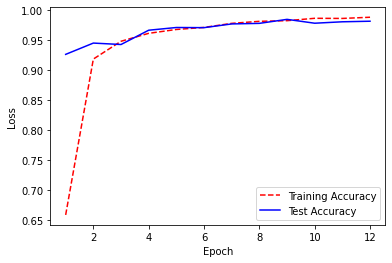

In [25]:
import matplotlib.pyplot as plt

training_loss = allCl.clients[0].history[0]['accuracy']
test_loss = allCl.clients[0].history[0]['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();


In [15]:
allCl.clients[0].get_nb_weights(1)

Current Node:  0
Untrained Neighbour:  [1, 2, 0]
All neighbours:  [1, 2, 0]
Training node  1
Training node  2
Training node  0
Current Node:  2
Untrained Neighbour:  [3]
All neighbours:  [0, 3, 2]
Training node  3
Current Node:  1
Untrained Neighbour:  [3]
All neighbours:  [0, 3, 1]
Training node  3


 4.50 MiB / 10.65 MiB   42.25%

Training finished for  0
Training finished for  3


Client  3  trained already.


 10.73 MiB / 10.73 MiB  100.00%

Training finished for  1


 10.73 MiB / 10.73 MiB  100.00%

Training finished for  2


In [16]:
print(allCl.clients[0].personal_accuracy, allCl.clients[1].personal_accuracy, allCl.clients[2].personal_accuracy, allCl.clients[3].personal_accuracy)

{0: 0.9611904621124268, 1: 0.9576190710067749} {0: 0.9395238161087036, 1: 0.9547619223594666} {0: 0.9616666436195374} {0: 0.9578571319580078}


In [17]:
allCl.clients[0].get_nb_weights(2)

Current Node:  0
Untrained Neighbour:  [1, 4, 0]
All neighbours:  [1, 4, 0]
Training node  1
Training node  4
Training node  0
Current Node:  4
Untrained Neighbour:  [3, 7]
All neighbours:  [3, 7, 0, 4]
Training node  3
Training node  7
Current Node:  1
Untrained Neighbour:  [5, 2]
All neighbours:  [0, 5, 2, 1]
Training node  5
Training node  2
Current Node:  3
Untrained Neighbour:  [6]
All neighbours:  [2, 4, 6, 3]
Training node  6
Current Node:  5
Untrained Neighbour:  []
All neighbours:  [1, 5]
Current Node: Current Node:  7
Untrained Neighbour:  2
 []
Untrained Neighbour:  All neighbours:  []
All neighbours: [4, 7]
 [3, 1, 2]


 18.97 MiB / 18.97 MiB  100.00%01s[2K

Training finished for  0


 18.87 MiB / 18.87 MiB  100.00%

Training finished for  7


 18.87 MiB / 18.87 MiB  100.00%

Training finished for  5


 18.77 MiB / 18.77 MiB  100.00%

Training finished for  6


Training finished for  2


 18.98 MiB / 18.98 MiB  100.00%%[2K39ss

Training finished for  3


 18.95 MiB / 18.95 MiB  100.00%1s

Training finished for  1


 18.97 MiB / 18.97 MiB  100.00%

Training finished for  4


In [18]:
print(allCl.clients[0].personal_accuracy, allCl.clients[1].personal_accuracy, allCl.clients[2].personal_accuracy, allCl.clients[3].personal_accuracy)

{0: 0.9611904621124268, 1: 0.9576190710067749, 2: 0.9435714483261108} {0: 0.9395238161087036, 1: 0.9547619223594666, 2: 0.9680952429771423} {0: 0.9616666436195374, 1: 0.9595237970352173} {0: 0.9578571319580078, 1: 0.9490476250648499}


In [19]:
allCl.clients[0].get_nb_weights(3)

Current Node:  0
Untrained Neighbour:  [1, 4, 0]
All neighbours:  [1, 4, 0]
Training node  1
Training node  4
Training node  0
Current Node:  1
Untrained Neighbour:  [5, 2]
All neighbours:  [0, 5, 2, 1]
Training node  5
Training node  2
Current Node:  4
Untrained Neighbour:  [3, 7]
All neighbours:  [3, 7, 0, 4]
Training node  Training node  7
3
Current Node:  5
Untrained Neighbour:  []
All neighbours:  [1, 5]
Current Node:  3
Untrained Neighbour:  [6]
All neighbours:  [2, 4, 6, 3]
Training node  6
Current Node:  7
Untrained Neighbour:  []
All neighbours:  [4, 7]


 7.96 MiB / 18.97 MiB   41.94% 00m01s

Current Node:  2
Untrained Neighbour:  []
All neighbours:  [3, 1, 2]


 8.80 MiB / 18.87 MiB   46.63%%00m01s

Current Node:  6
Untrained Neighbour:  []
All neighbours:  [3, 6]


 18.95 MiB / 18.95 MiB  100.00%%[2K1sK[2K

Training finished for  0


 18.91 MiB / 18.91 MiB  100.00%

Training finished for  5


 18.91 MiB / 18.91 MiB  100.00%

Training finished for  7


 18.88 MiB / 18.88 MiB  100.00%

Training finished for  6


 0 B / 18.93 MiB    0.00%9.73%%

Training finished for  2


 18.96 MiB / 18.96 MiB  100.00%m11s[2K[2K

Training finished for  3


Training finished for  1


 18.96 MiB / 18.96 MiB  100.00%

Training finished for  4


In [19]:
print(allCl.clients[0].personal_accuracy, allCl.clients[1].personal_accuracy, allCl.clients[2].personal_accuracy, allCl.clients[3].personal_accuracy)

In [20]:
allCl.clients[0].get_nb_weights(4)

Current Node:  0
Untrained Neighbour:  [1, 4, 0]
All neighbours:  [1, 4, 0]
Training node  1
Training node  Training node  0
4
Current Node:  4
Untrained Neighbour:  [3, 7]
All neighbours:  [3, 7, 0, 4]
Training node  Training node 3 7

Current Node:  1
Untrained Neighbour:  [5, 2]
All neighbours:  [0, 5, 2, 1]
Training node  5
Training node  2
Current Node:  7
Untrained Neighbour:  []
All neighbours:  [4, 7]
Current Node:  5
Untrained Neighbour:  []
All neighbours:  [1, 5]
Current Node:  2
Untrained Neighbour:  []
All neighbours:  [3, 1, 2]


 3.04 MiB / 18.91 MiB   16.05% 00m06s9s

Current Node:  3
Untrained Neighbour:  [6]
All neighbours:  [2, 4, 6, 3]
Training node  6


 1.69 MiB / 18.95 MiB    8.91% 00m14s9s2KK

Current Node:  6
Untrained Neighbour:  []
All neighbours:  [3, 6]


 18.94 MiB / 18.94 MiB  100.00%%[2K02ss[2K

Training finished for  0


 18.90 MiB / 18.90 MiB  100.00%

Training finished for  5


 256.00 KiB / 18.91 MiB    1.32%[2K

Training finished for  6


 18.91 MiB / 18.91 MiB  100.00%

Training finished for  7


 18.96 MiB / 18.96 MiB  100.00%5s2K

Training finished for  2


 18.96 MiB / 18.96 MiB  100.00%40s[2K

Training finished for  3


Training finished for  1


 18.94 MiB / 18.94 MiB  100.00%

Training finished for  4


In [21]:
allCl.clients[0].personal_accuracy, allCl.clients[1].personal_accuracy, allCl.clients[2].personal_accuracy, allCl.clients[3].personal_accuracy

({0: 0.9611904621124268,
  1: 0.9576190710067749,
  2: 0.9435714483261108,
  3: 0.9695237874984741,
  4: 0.9480952620506287},
 {0: 0.9395238161087036,
  1: 0.9547619223594666,
  2: 0.9680952429771423,
  3: 0.9697619080543518,
  4: 0.9766666889190674},
 {0: 0.9616666436195374,
  1: 0.9595237970352173,
  2: 0.9611904621124268,
  3: 0.9690476059913635},
 {0: 0.9578571319580078,
  1: 0.9490476250648499,
  2: 0.9607142806053162,
  3: 0.9657142758369446})

In [22]:
# allCl.clients[0].get_nb_weights(4)

In [23]:
# allCl.clients[0].personal_accuracy, allCl.clients[1].personal_accuracy, allCl.clients[2].personal_accuracy, allCl.clients[3].personal_accuracy

In [24]:
# allCl.clients[0].get_nb_weights(5)